## Tongue tip detection for click

This notebooke prompts the user to stick out their tongue, and move their head around to build a training dataset. It then builds a model for classification. 

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from imutils import paths
import imutils
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

import tensorflow as tf

from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
#set up the haar cascade classifier to put a bounding box around the face
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [ ]:
## code to help with camera

# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
tongue_out_examples = []
other_examples = []

In [ ]:
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
print('DATA CAPTURING PHASE')
print('stick the tip of your tongue out and scan all corners of the screen until the next message')
for i in range(200):
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(32, 32), flags=cv2.CASCADE_SCALE_IMAGE)

    for (x,y,w,h) in faces:
      # bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)
      roi = gray[y:y + h, x:x+w]
      roi = cv2.resize(roi, (32, 32))
      roi = roi.astype("float") / 255.0
      roi = img_to_array(roi)
      roi = np.expand_dims(roi, axis=0)
      
      tongue_out_examples.append(roi)
      print(200-i)

print('now relax your face to a normal resting position and scan the screen until the next message')
for i in range(200):
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)

    for (x,y,w,h) in faces:
      # bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)
      roi = gray[y:y + h, x:x+w]
      roi = cv2.resize(roi, (32, 32))
      roi = roi.astype("float") / 255.0
      roi = img_to_array(roi)
      roi = np.expand_dims(roi, axis=0)
      
      other_examples.append(roi)
      print(200-i)

print('now make various common facial expressions and scan the screen until prompted')
for i in range(200):
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)

    for (x,y,w,h) in faces:
      # bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)
      roi = gray[y:y + h, x:x+w]
      roi = cv2.resize(roi, (32, 32))
      roi = roi.astype("float") / 255.0
      roi = img_to_array(roi)
      roi = np.expand_dims(roi, axis=0)
      
      other_examples.append(roi)
      print(200-i)
      
print('data collection complete!')

<IPython.core.display.Javascript object>

DATA CAPTURING PHASE
stick the tip of your tongue out and scan all corners of the screen until the next message
200
199
198
197
196
196
195
195
194
194
193
192
191
191
190
189
188
187
186
185
184
183
182
181
180
179
178
177
176
175
174
174
173
172
171
170
169
168
167
166
165
164
163
162
161
160
159
158
157
156
155
154
153
152
152
151
150
149
148
148
147
147
146
146
145
145
144
144
143
143
142
142
141
141
140
140
139
139
138
138
137
137
136
136
135
135
134
134
133
133
132
132
131
131
130
130
129
129
128
128
127
127
126
126
125
125
124
124
123
123
122
122
121
121
120
120
119
119
118
118
117
117
116
116
115
115
114
113
112
112
111
111
110
110
109
108
107
107
106
106
105
104
104
103
103
102
102
101
101
100
100
99
99
98
98
97
97
96
96
95
95
94
94
93
93
92
91
91
90
89
89
88
88
87
87
86
86
85
85
84
84
83
83
82
82
81
80
80
79
79
78
78
77
77
76
76
75
75
74
74
73
73
72
72
71
71
70
70
69
69
68
68
67
67
66
66
65
65
64
64
63
63
62
62
61
61
60
60
59
59
58
58
57
56
56
55
55
54
54
53
53
52
52
51
51
50

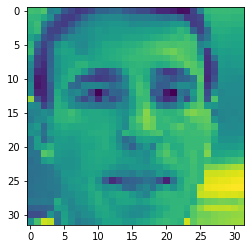

In [ ]:
tongue_out_examples_arr = np.array(tongue_out_examples)
tongue_out_examples_arr.shape
plt.imshow(tongue_out_examples_arr[10].reshape(32,32))


In [ ]:
tongue_out_examples_arr = tongue_out_examples_arr.reshape(tongue_out_examples_arr.shape[0], 32, 32)
tongue_out_examples_arr.shape
positives = np.ones(tongue_out_examples_arr.shape[0])

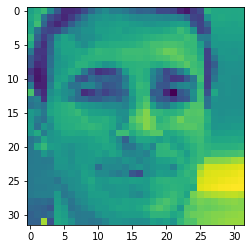

In [ ]:
other_examples_arr = np.array(other_examples)
other_examples_arr.shape
plt.imshow(other_examples_arr[90].reshape(32,32))
other_examples_arr = other_examples_arr.reshape(other_examples_arr.shape[0], 32, 32)
negatives = np.zeros(other_examples_arr.shape[0])

In [ ]:
x = np.concatenate((tongue_out_examples_arr, other_examples_arr), axis = 0)
y = np.concatenate((positives, negatives), axis = 0)
indices = np.random.permutation(x.shape[0])
n = int(x.shape[0]*0.8)
training_idx, test_idx = indices[:n], indices[n:]
x_train, x_test = x[training_idx,:], x[test_idx,:]
y_train, y_test = y[training_idx], y[test_idx]

In [ ]:
x_train.shape

(607, 32, 32)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(32, 32, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(.2),

    tf.keras.layers.Conv2D(16, (4,4), activation='relu', input_shape=(32, 32, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(196, activation='relu'),
    tf.keras.layers.Dense(98, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
model.fit(x_train.reshape(x_train.shape[0], 32,32,1), y_train, epochs=10)

Epoch 1/10
19/19 [==============================] - 2s 38ms/step - loss: 0.5306 - accuracy: 0.7809
Epoch 2/10
19/19 [==============================] - 1s 38ms/step - loss: 0.3045 - accuracy: 0.8913
Epoch 3/10
19/19 [==============================] - 1s 37ms/step - loss: 0.2145 - accuracy: 0.9226
Epoch 4/10
19/19 [==============================] - 1s 38ms/step - loss: 0.2194 - accuracy: 0.9176
Epoch 5/10
19/19 [==============================] - 1s 38ms/step - loss: 0.1807 - accuracy: 0.9390
Epoch 6/10
19/19 [==============================] - 1s 37ms/step - loss: 0.1450 - accuracy: 0.9489
Epoch 7/10
19/19 [==============================] - 1s 38ms/step - loss: 0.1263 - accuracy: 0.9506
Epoch 8/10
19/19 [==============================] - 1s 38ms/step - loss: 0.1109 - accuracy: 0.9572
Epoch 9/10
19/19 [==============================] - 1s 39ms/step - loss: 0.1064 - accuracy: 0.9522
Epoch 10/10
19/19 [==============================] - 1s 39ms/step - loss: 0.1181 - accuracy: 0.9539


In [ ]:
model.evaluate(x_test.reshape(x_test.shape[0], 32,32,1), y_test)

5/5 [==============================] - 0s 10ms/step - loss: 0.6037 - accuracy: 0.6382


[0.6036560535430908, 0.6381579041481018]

In [ ]:
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)

    for (x,y,w,h) in faces:
      # bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)
      roi = gray[y:y + h, x:x+w]
      roi = cv2.resize(roi, (32, 32))
      roi = roi.astype("float") / 255.0
      roi = img_to_array(roi)
      roi = np.expand_dims(roi, axis=0)

      tongue_out = model.predict(roi)[0]
      # print(smiling)
      # if smiling[0] > smiling[1]:
      #   print('SMILING!')
      # else:
      #   print('NOT SMILING')

      if tongue_out > 0.2:
        print('tongue out! = ', tongue_out)
        y_hat = 1
      else:
        print('not tongue out, = ', tongue_out)

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 12ms/step
not tongue out, =  [0.09531371]
1/1 [==============================] - 0s 13ms/step
not tongue out, =  [0.04560203]
1/1 [==============================] - 0s 13ms/step
not tongue out, =  [0.04947499]
1/1 [==============================] - 0s 18ms/step
not tongue out, =  [0.02897872]
1/1 [==============================] - 0s 14ms/step
not tongue out, =  [0.04203939]
1/1 [==============================] - 0s 13ms/step
not tongue out, =  [0.04140589]
1/1 [==============================] - 0s 13ms/step
not tongue out, =  [0.03984653]
1/1 [==============================] - 0s 12ms/step
tongue out! =  [0.6033058]
1/1 [==============================] - 0s 13ms/step
tongue out! =  [0.60840595]
1/1 [==============================] - 0s 12ms/step
tongue out! =  [0.28922212]
1/1 [==============================] - 0s 12ms/step
not tongue out, =  [0.18485515]
1/1 [==============================] - 0s 12ms/step
not tongue out, =  [0.14485396]
1/1 [

KeyboardInterrupt: ignored